In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

weather_auckland = pd.read_csv("../AucklandMotatStationNiwa_08June24/motatstation_weather_auckland_2016_2024.csv",  parse_dates=True)

weather_auckland.head()

,Date,WDir(Deg),WSpd(m/s),GustDir(Deg),GustSpd(m/s),WindRun(Km),Rain(mm),Tdry(c),Twet(c),RH(%),...,ET10©,ET20©,ET100©,Pmsl(hPa),Pstn(hPa),Sun(Hrs),Rad(MJ/m2),Tavg,Evaporation(mm),SoilMoist(%)
0,20160301,188.0,1.2,65.0,7.2,172.0,1.8,19.2,18.5,93.0,...,21.3,22.2,21.5,1014.4,1012.5,1.3,6.21,20.40,0.9,37.4
1,20160302,157.0,3.2,60.0,9.3,258.0,0.0,17.9,16.1,82.0,...,20.4,21.7,21.5,1019.3,1017.4,7.6,15.02,20.25,1.8,37.6
2,20160303,134.0,1.9,67.0,10.8,214.0,0.0,18.3,15.7,75.0,...,19.5,20.9,21.5,1028.0,1026.1,9.4,20.46,19.20,4.2,37.6
3,20160304,147.0,1.3,38.0,6.2,134.0,0.0,19.4,16.1,69.0,...,19.9,21.2,21.6,1027.6,1025.7,9.3,19.20,19.60,4.2,37.7
4,20160305,131.0,0.4,197.0,9.3,187.0,0.0,19.0,17.3,84.0,...,19.9,21.2,21.5,1025.6,1023.7,12.1,24.18,19.75,4.0,37.8


In [101]:
test_size_percentage = 0.20
test_size = int(len(weather_auckland) * test_size_percentage)

train_data = weather_auckland.iloc[:-test_size]
test_data = weather_auckland.iloc[-test_size:]
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (2352, 23)
Test data shape: (587, 23)


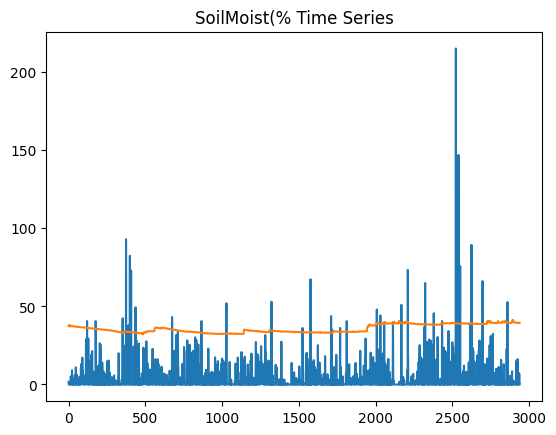

In [102]:
# Visual Inspection to choose between additive and multiplicative method for the Holt-Winters model
import matplotlib.pyplot as plt

weather_auckland['Rain(mm)'].plot(title='Rain(mm) Time Series')
weather_auckland['SoilMoist(%)'].plot(title='SoilMoist(% Time Series')
plt.show()

In [103]:
lag_size = 14


target_variable = ['Rain(mm)', 'SoilMoist(%)']

for column in weather_auckland.columns:
    for i in range(1, lag_size + 1):
        weather_auckland[f'{column}_lag_{i}'] = weather_auckland[column].shift(i)
        

weather_auckland.dropna(inplace=True) 

C:\Users\Ying\AppData\Local\Temp\ipykernel_14780\1340120115.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weather_auckland[f'{column}_lag_{i}'] = weather_auckland[column].shift(i)
C:\Users\Ying\AppData\Local\Temp\ipykernel_14780\1340120115.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weather_auckland[f'{column}_lag_{i}'] = weather_auckland[column].shift(i)
C:\Users\Ying\AppData\Local\Temp\ipykernel_14780\1340120115.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

Typically, an additive model is used when seasonal fluctuations are roughly constant through the series, while a multiplicative model is used when seasonal fluctuations increase or decrease proportionally with the level of the series.

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Adding a small constant to handle zero or negative values
weather_auckland['Rain(mm)_pos'] = weather_auckland['Rain(mm)'] + 1e-6
weather_auckland['SoilMoist(%)_pos'] = weather_auckland['SoilMoist(%)'] + 1e-6

period = 30

# Decompose Rain(mm) time series
decomposition_add_rain = seasonal_decompose(weather_auckland['Rain(mm)'], model='additive', period=period)
decomposition_mul_rain = seasonal_decompose(weather_auckland['Rain(mm)_pos'], model='multiplicative', period=period)

# Decompose SoilMoist(%) time series
decomposition_add_soilmoist = seasonal_decompose(weather_auckland['SoilMoist(%)'], model='additive', period=period)
decomposition_mul_soilmoist = seasonal_decompose(weather_auckland['SoilMoist(%)_pos'], model='multiplicative', period=period)


C:\Users\Ying\AppData\Local\Temp\ipykernel_14780\3134589135.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weather_auckland['Rain(mm)_pos'] = weather_auckland['Rain(mm)'] + 1e-6
C:\Users\Ying\AppData\Local\Temp\ipykernel_14780\3134589135.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weather_auckland['SoilMoist(%)_pos'] = weather_auckland['SoilMoist(%)'] + 1e-6


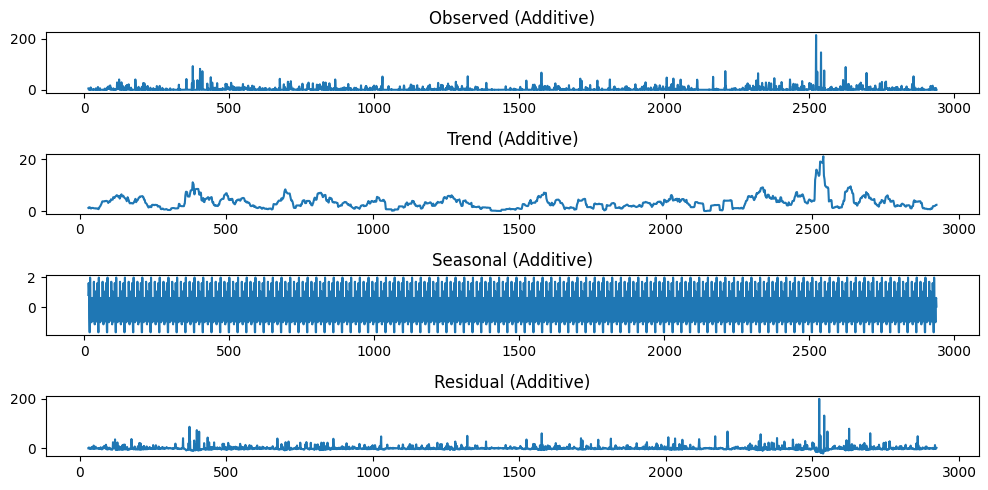

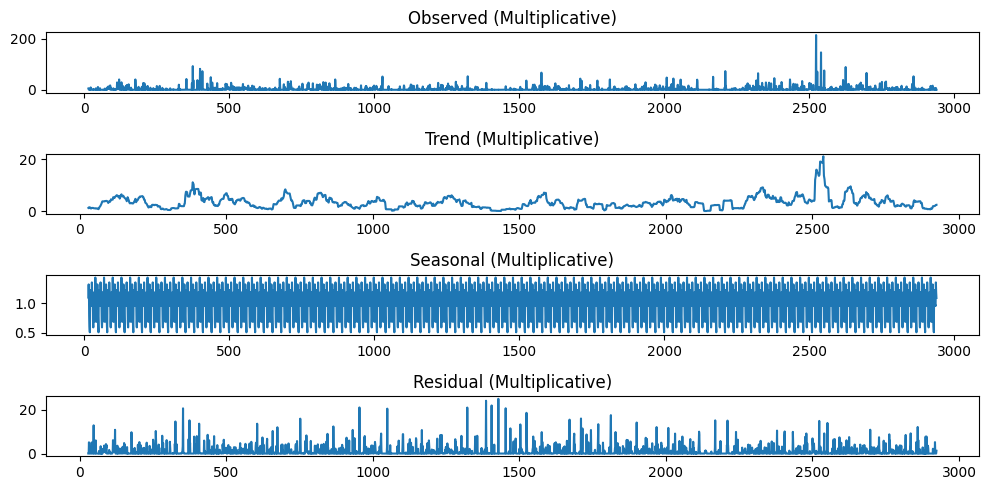

In [105]:
# Plot Additive Decomposition for Rain(mm)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 5))
ax1.plot(decomposition_add_rain.observed)
ax1.set_title('Observed (Additive)')
ax2.plot(decomposition_add_rain.trend)
ax2.set_title('Trend (Additive)')
ax3.plot(decomposition_add_rain.seasonal)
ax3.set_title('Seasonal (Additive)')
ax4.plot(decomposition_add_rain.resid)
ax4.set_title('Residual (Additive)')
plt.tight_layout()
plt.show()

# Plot Multiplicative Decomposition for Rain(mm)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 5))
ax1.plot(decomposition_mul_rain.observed)
ax1.set_title('Observed (Multiplicative)')
ax2.plot(decomposition_mul_rain.trend)
ax2.set_title('Trend (Multiplicative)')
ax3.plot(decomposition_mul_rain.seasonal)
ax3.set_title('Seasonal (Multiplicative)')
ax4.plot(decomposition_mul_rain.resid)
ax4.set_title('Residual (Multiplicative)')
plt.tight_layout()
plt.show()

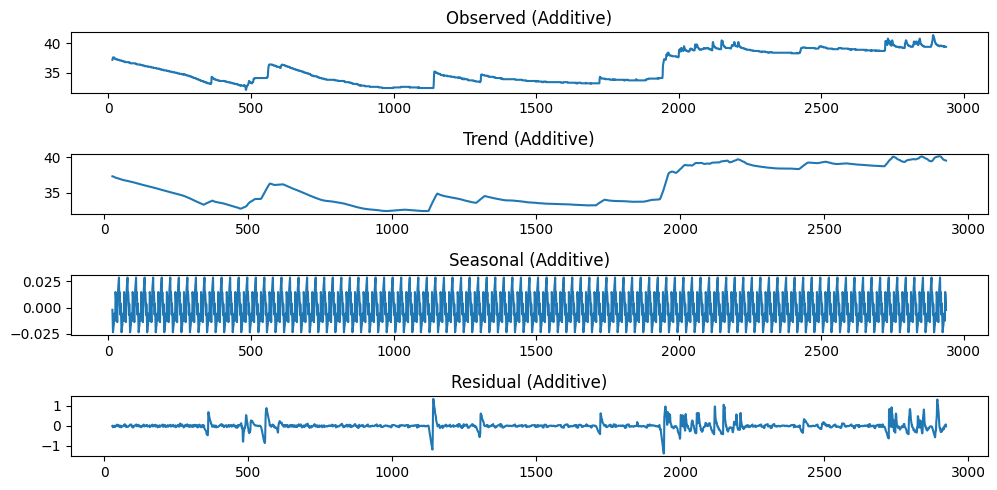

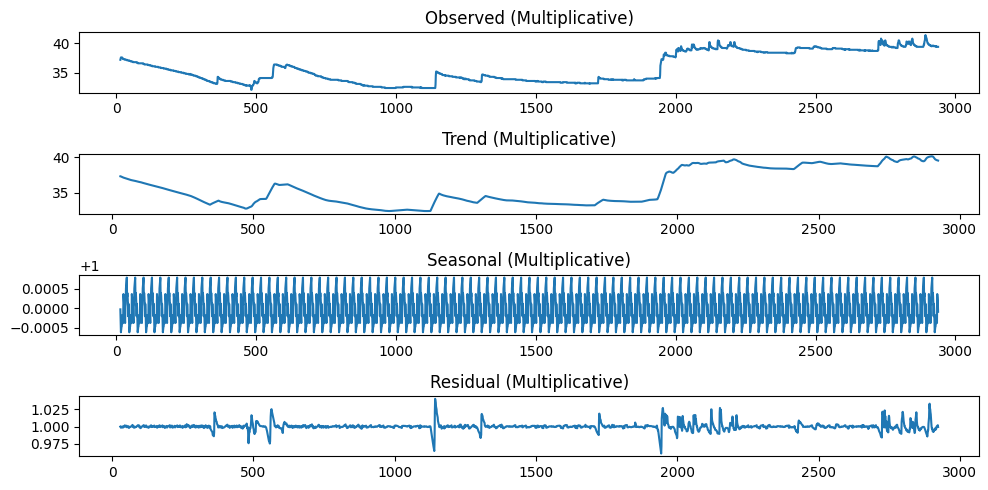

In [106]:
# Plot Additive Decomposition for SoilMoist(%)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 5))
ax1.plot(decomposition_add_soilmoist.observed)
ax1.set_title('Observed (Additive)')
ax2.plot(decomposition_add_soilmoist.trend)
ax2.set_title('Trend (Additive)')
ax3.plot(decomposition_add_soilmoist.seasonal)
ax3.set_title('Seasonal (Additive)')
ax4.plot(decomposition_add_soilmoist.resid)
ax4.set_title('Residual (Additive)')
plt.tight_layout()
plt.show()

# Plot Multiplicative Decomposition for SoilMoist(%)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 5))
ax1.plot(decomposition_mul_soilmoist.observed)
ax1.set_title('Observed (Multiplicative)')
ax2.plot(decomposition_mul_soilmoist.trend)
ax2.set_title('Trend (Multiplicative)')
ax3.plot(decomposition_mul_soilmoist.seasonal)
ax3.set_title('Seasonal (Multiplicative)')
ax4.plot(decomposition_mul_soilmoist.resid)
ax4.set_title('Residual (Multiplicative)')
plt.tight_layout()
plt.show()

In [107]:
# Print Additive Decomposition for Rain(mm)
print("Additive Decomposition for Rain(mm):")
print("Trend:")
print(decomposition_add_rain.trend.head())
print("\nSeasonal:")
print(decomposition_add_rain.seasonal.head())
print("\nResidual:")
print(decomposition_add_rain.resid.head())



Additive Decomposition for Rain(mm):
Trend:
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
Name: trend, dtype: float64

Seasonal:
14    0.827666
15    1.623499
16    1.198673
17   -0.684417
18   -1.657091
Name: seasonal, dtype: float64

Residual:
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
Name: resid, dtype: float64


In [108]:
# Print Multiplicative Decomposition for Rain(mm)
print("Multiplicative Decomposition for Rain(mm):")
print("Trend:")
print(decomposition_mul_rain.trend.head())
print("\nSeasonal:")
print(decomposition_mul_rain.seasonal.head())
print("\nResidual:")
print(decomposition_mul_rain.resid.head())

Multiplicative Decomposition for Rain(mm):
Trend:
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
Name: trend, dtype: float64

Seasonal:
14    1.098033
15    1.321370
16    1.114759
17    0.791798
18    0.603114
Name: seasonal, dtype: float64

Residual:
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
Name: resid, dtype: float64


In [109]:
# Print Additive Decomposition for SoilMoist(%)
print("Additive Decomposition for SoilMoist(%):")
print("Trend:")
print(decomposition_add_soilmoist.trend.head())
print("\nSeasonal:")
print(decomposition_add_soilmoist.seasonal.head())
print("\nResidual:")
print(decomposition_add_soilmoist.resid.head())



Additive Decomposition for SoilMoist(%):
Trend:
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
Name: trend, dtype: float64

Seasonal:
14   -0.002161
15   -0.011310
16   -0.023585
17   -0.021293
18   -0.017960
Name: seasonal, dtype: float64

Residual:
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
Name: resid, dtype: float64


In [110]:
print("Multiplicative Decomposition for SoilMoist(%):")
print("Trend:")
print(decomposition_mul_soilmoist.trend.head())
print("\nSeasonal:")
print(decomposition_mul_soilmoist.seasonal.head())
print("\nResidual:")
print(decomposition_mul_soilmoist.resid.head())

Multiplicative Decomposition for SoilMoist(%):
Trend:
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
Name: trend, dtype: float64

Seasonal:
14    0.999972
15    0.999711
16    0.999389
17    0.999461
18    0.999522
Name: seasonal, dtype: float64

Residual:
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
Name: resid, dtype: float64


In [123]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_data['Rain(mm)_pos'] = train_data['Rain(mm)'] + 1
train_data['SoilMoist(%)_pos'] = train_data['SoilMoist(%)'] + 1

fitted_model_rain = ExponentialSmoothing(train_data['Rain(mm)_pos'], trend='add', seasonal='add', seasonal_periods=30).fit()
fitted_model_soilmoist = ExponentialSmoothing(train_data['SoilMoist(%)_pos'], trend='add', seasonal='add', seasonal_periods=12).fit()


C:\Users\Ying\AppData\Local\Temp\ipykernel_14780\511231012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Rain(mm)_pos'] = train_data['Rain(mm)'] + 1
C:\Users\Ying\AppData\Local\Temp\ipykernel_14780\511231012.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['SoilMoist(%)_pos'] = train_data['SoilMoist(%)'] + 1


In [124]:
test_prediction_rain = fitted_model_rain.forecast(steps=12)
test_prediction_soilmoist = fitted_model_soilmoist.forecast(steps=12)

In [125]:
test_prediction_rain_backtransformed = test_prediction_rain - 1
test_prediction_soilmoist_backtransformed = test_prediction_soilmoist - 1

In [126]:
print("Rain(mm) Forecast:")
print(test_prediction_rain)
print()

print("SoilMoist(%) Forecast:")
print(test_prediction_soilmoist)
print()

Rain(mm) Forecast:
2352    7.683271
2353    8.504046
2354    9.474229
2355    8.308487
2356    9.725910
2357    7.689856
2358    6.681644
2359    6.502315
2360    8.846217
2361    8.798390
2362    8.441493
2363    8.007346
dtype: float64

SoilMoist(%) Forecast:
2352    39.395770
2353    39.402847
2354    39.409409
2355    39.408819
2356    39.400575
2357    39.405593
2358    39.394792
2359    39.394185
2360    39.387953
2361    39.381738
2362    39.377562
2363    39.373374
dtype: float64



<Axes: >

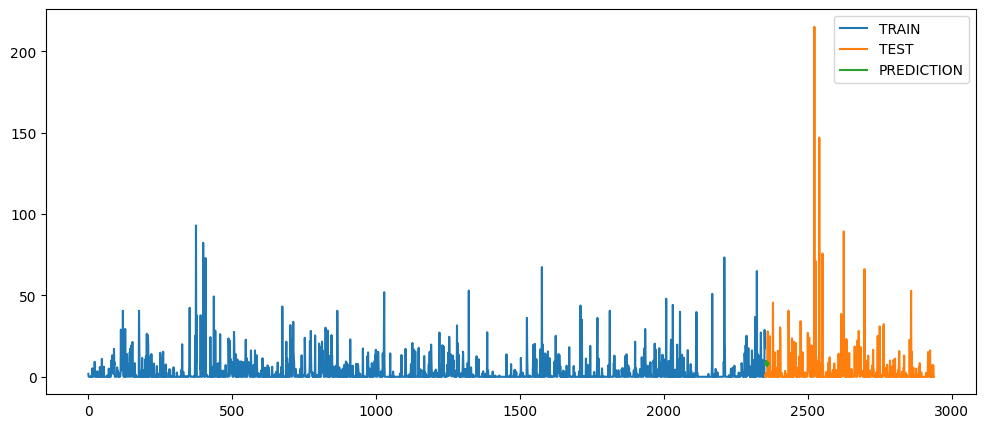

In [127]:
train_data['Rain(mm)'].plot(legend=True, label='TRAIN', figsize=(12,5))
test_data['Rain(mm)'].plot(legend=True, label='TEST')
test_prediction_rain.plot(legend=True, label='PREDICTION')

<Axes: >

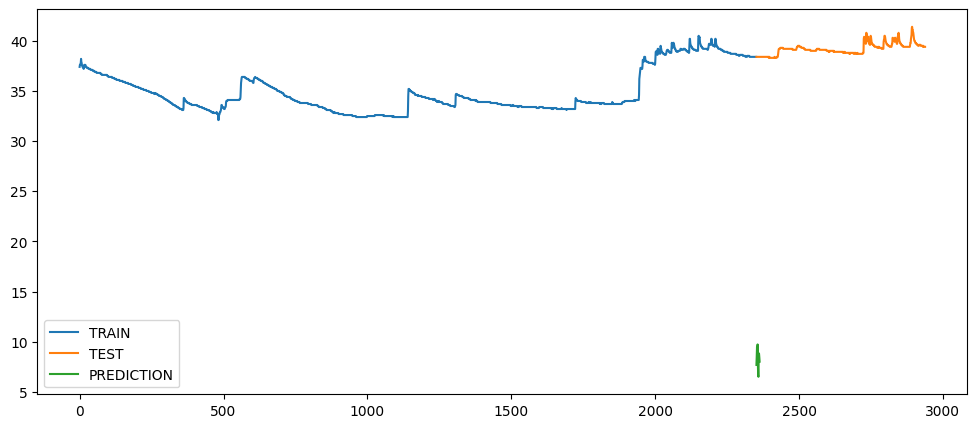

In [128]:
train_data['SoilMoist(%)'].plot(legend=True, label='TRAIN', figsize=(12,5))
test_data['SoilMoist(%)'].plot(legend=True, label='TEST')
test_prediction_rain.plot(legend=True, label='PREDICTION')

In [129]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
test_prediction_rain = fitted_model_rain.forecast(steps=len(test_data))
test_data_rain = test_data['Rain(mm)'][:len(test_prediction_rain)]
mae_rain = mean_absolute_error(test_data_rain, test_prediction_rain)
mse_rain = mean_squared_error(test_data_rain, test_prediction_rain)

print("Mean Absolute Error for Rain(mm):", mae_rain)
print("Mean Squared Error for Rain(mm):", mse_rain)

test_prediction_soilmoist = fitted_model_soilmoist.forecast(steps=len(test_data))
test_data_soilmoist = test_data['SoilMoist(%)'][:len(test_prediction_rain)]
mae_soil = mean_absolute_error(test_data_soilmoist, test_prediction_soilmoist)
mse_soil = mean_squared_error(test_data_soilmoist, test_prediction_soilmoist)

print("Mean Absolute Error for SoilMoist(%):", mae_soil)
print("Mean Squared Error for SoilMoist(%):", mse_soil)

Mean Absolute Error for Rain(mm): 8.94792425749919
Mean Squared Error for Rain(mm): 216.21280879125038
Mean Absolute Error for SoilMoist(%): 0.699848257406954
Mean Squared Error for SoilMoist(%): 0.9280433244250295


### Correlation is a measure of the strength of the linear relationship between two variables

C:\Users\Ying\AppData\Local\Temp\ipykernel_14780\2259179985.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Rain(mm)_pos'] = train_data['Rain(mm)'] + 1
C:\Users\Ying\AppData\Local\Temp\ipykernel_14780\2259179985.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['SoilMoist(%)_pos'] = train_data['SoilMoist(%)'] + 1


Rain(mm) Forecast:
2352    6.801250
2353    7.260129
2354    8.505155
2355    8.095558
2356    9.148525
2357    6.758077
2358    7.152199
2359    7.525459
2360    8.236044
2361    7.390244
2362    7.026314
2363    7.460473
dtype: float64

SoilMoist(%) Forecast:
2352    39.395770
2353    39.402847
2354    39.409409
2355    39.408819
2356    39.400575
2357    39.405593
2358    39.394792
2359    39.394185
2360    39.387953
2361    39.381738
2362    39.377562
2363    39.373374
dtype: float64



<Axes: >

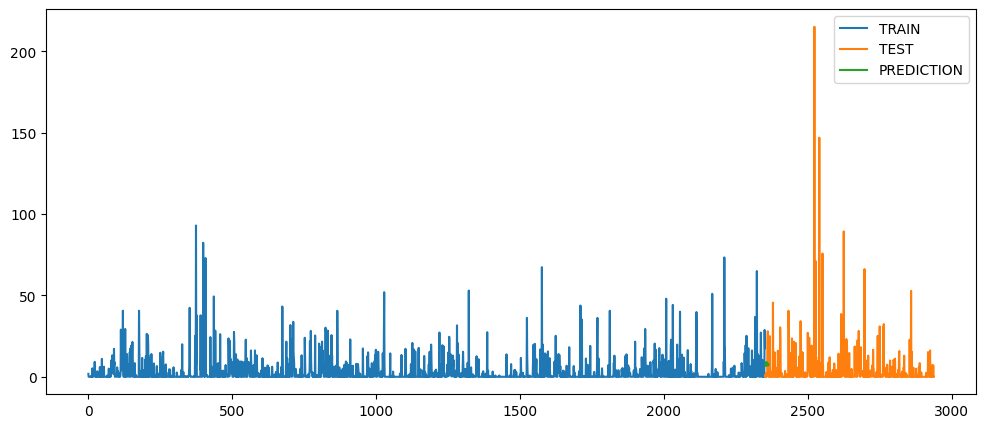

In [130]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_data['Rain(mm)_pos'] = train_data['Rain(mm)'] + 1
train_data['SoilMoist(%)_pos'] = train_data['SoilMoist(%)'] + 1

fitted_model_rain = ExponentialSmoothing(train_data['Rain(mm)_pos'], trend='add', seasonal='add', seasonal_periods=12).fit()
fitted_model_soilmoist = ExponentialSmoothing(train_data['SoilMoist(%)_pos'], trend='add', seasonal='add', seasonal_periods=12).fit()

test_prediction_rain = fitted_model_rain.forecast(steps=12)
test_prediction_soilmoist = fitted_model_soilmoist.forecast(steps=12)

test_prediction_rain_backtransformed = test_prediction_rain - 1
test_prediction_soilmoist_backtransformed = test_prediction_soilmoist - 1

print("Rain(mm) Forecast:")
print(test_prediction_rain)
print()

print("SoilMoist(%) Forecast:")
print(test_prediction_soilmoist)
print()

train_data['Rain(mm)'].plot(legend=True, label='TRAIN', figsize=(12,5))
test_data['Rain(mm)'].plot(legend=True, label='TEST')
test_prediction_rain.plot(legend=True, label='PREDICTION')



<Axes: >

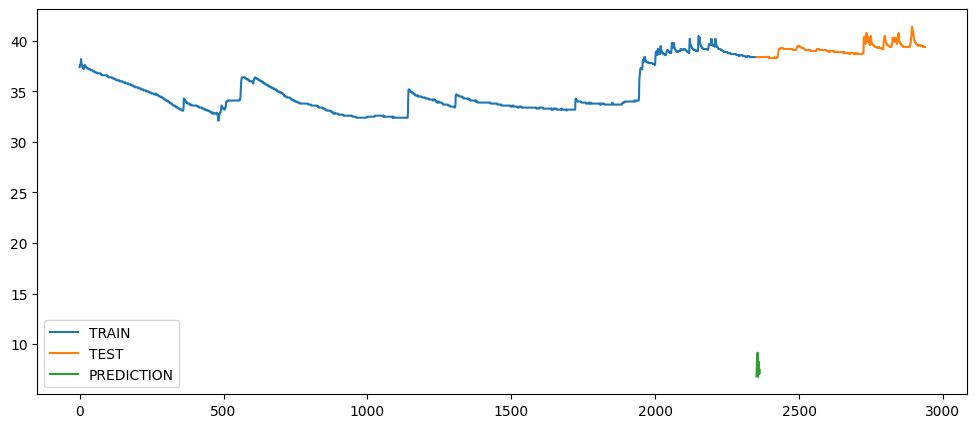

In [131]:
train_data['SoilMoist(%)'].plot(legend=True, label='TRAIN', figsize=(12,5))
test_data['SoilMoist(%)'].plot(legend=True, label='TEST')
test_prediction_rain.plot(legend=True, label='PREDICTION')

In [132]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
test_prediction_rain = fitted_model_rain.forecast(steps=len(test_data))
test_data_rain = test_data['Rain(mm)'][:len(test_prediction_rain)]
mae_rain = mean_absolute_error(test_data_rain, test_prediction_rain)
mse_rain = mean_squared_error(test_data_rain, test_prediction_rain)

print("Mean Absolute Error for Rain(mm):", mae_rain)
print("Mean Squared Error for Rain(mm):", mse_rain)

test_prediction_soilmoist = fitted_model_soilmoist.forecast(steps=len(test_data))
test_data_soilmoist = test_data['SoilMoist(%)'][:len(test_prediction_rain)]
mae_soil = mean_absolute_error(test_data_soilmoist, test_prediction_soilmoist)
mse_soil = mean_squared_error(test_data_soilmoist, test_prediction_soilmoist)

print("Mean Absolute Error for SoilMoist(%):", mae_soil)
print("Mean Squared Error for SoilMoist(%):", mse_soil)

Mean Absolute Error for Rain(mm): 8.585318074538876
Mean Squared Error for Rain(mm): 210.8845227447626
Mean Absolute Error for SoilMoist(%): 0.699848257406954
Mean Squared Error for SoilMoist(%): 0.9280433244250295
